# Matrix Factorization for Movie Recommendations in Python

### Overview

In this project, I will build an model-based collaborative filtering system using MovieLens Datasets. specifically, I will implement Model-Based CF by using singular value decomposition (SVD).

### Recommender System
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use item-based collaborative filtering systems to make movie recommendation

### Model-based Collaborative Filtering
Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

### Content Overview
* Importing Data
* Data Cleaning
* Fit Low Rank Matrix Factorization Model
  1. Choose Optimal Estimator: 5-fold cross validation
  2. Multithreading Optimization of CV Running Time
* Recommendation
* Model Evaluation in Individual Level
* Conclusion

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

from collections import defaultdict #data colector

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

#CrossValidation
from surprise.model_selection import cross_validate


#Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

np.random.seed(42) # replicating results

### Importing the data

Firstly, we need to download the MovieLens dat files from website and import the data.

In [2]:
dat_set = ['movies.dat', 'users.dat', 'ratings.dat']
csv_set = ['movies.csv', 'users.csv', 'ratings.csv']
name_set = [["MovieId", "Title", "Genres"], ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],
            ['UserID', 'MovieId', 'Rating', 'Timestamp']]
df_name = ['movies', 'users', 'ratings']

for k in range(0, len(dat_set)):
    with open(dat_set[k], encoding="ISO-8859-1") as dat_file, open(csv_set[k], 'w') as csv_file:
        csv_writer = csv.writer(csv_file)

        for line in dat_file:
            row = [field.strip() for field in line.split('::')]
            csv_writer.writerow(row)

    df_name[k] = pd.read_csv(csv_set[k], names=name_set[k])

df_movies = df_name[0]
df_users = df_name[1]
df_ratings = df_name[2]

df_movies['MovieId'] = df_movies['MovieId'].apply(pd.to_numeric)
df_ratings['Rating'] = df_ratings['Rating'].apply(lambda x: int(x))

### Data Cleaning



Before we train the model, we will take a look at the movies and ratings dataframe and filter and demean the dataframe based on our "MovieLens 1M Data Exploratory Analysis Report".

* Filter the ratings dataframe

In [3]:
df_movies.head()

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,UserID,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


These look good, but from our previous data exploratory report, we find some outliers which only rated once and got rating score as high as 5. Therefore, we filter the rating table to only include movies which have at least 2 ratings and users who rate at least 5 times. 

Dropping out less known movies can improve recommendation quality.

In [5]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = df_ratings.groupby("MovieId").filter(lambda x: x['MovieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("UserID").filter(lambda x: x['UserID'].count() >= min_user_ratings)


"{0} movies deleted; all movies are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(df_ratings.MovieId.value_counts()) - len(ratings_flrd_df.MovieId.value_counts())\
        ,min_movie_ratings,df_ratings.shape, ratings_flrd_df.shape )

'114 movies deleted; all movies are now rated at least: 2 times. Old dimensions: (1000209, 4); New dimensions: (1000095, 4)'

Now let's take a quick look at the number of unique users and movies.

In [6]:
n_users = ratings_flrd_df['UserID'].nunique()
n_items = ratings_flrd_df['MovieId'].nunique()

print('Num of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num of Users: 6040
Num of Movies: 3592


Intuitively, not every user has rated every movie, and it's a bit nonsensical to expect them to. Working with Sparse data (data with a lot of NaNs)is very different — and that’s what makes Recommendation an interesting problem. Let's calculate the sparsity level of MovieLens dataset:

In [7]:
sparsity=round(1.0-len(ratings_flrd_df)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 95.39999999999999%


Now we would like to create a dummy variable to map between the movie id and column index.

In [8]:
movie_list = ratings_flrd_df['MovieId'].unique()
movie_list.sort()

movie_to_idx = {movie: index for index, movie in enumerate (movie_list)}

### Fit Low Rank Matrix Factorization Model

After filtering the dataset, we want to discover the structures. With high-dimentional raw data, it's hard to extract information. The goal of matrix factorization is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. Let's train the SVD model and examine the effect of number of latent factors k on the model's performance now.

We will read the data first.

In [9]:
reader = Reader(rating_scale=(0, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["UserID", "MovieId", "Rating"]], reader=reader)

#### Evaluate Estimator Performance

* 5-fold cross validation


As we train any model on the training set, it tends to overfit or underfit most of the time, and in order to avoid this situation, we use regularization techniques. Cross validation is a good technique to evaluate the estimator performance. To find the best performance of latent factor, we use 5 fold cross validation. A list of mean RMSE of CV = 5 in cross_validate() for each factor k in range(1, 101, 1) will be returned.

* Multithreading for optimization


Since 5-fold cross validation randomly splits the dataset into 5 testsets and tests 5 times for each factor k, the running time is very slow. To optimize the process, we create a queue and 4 threads which will pick task from the queue. Once the task is finished, it will be removed from the queue. The multithreading optimizes the running time. 

In [ ]:
import threading
import time

PARALLEL_SIZE = 4

threadLock = threading.Lock()
rmse_algo_map = {}
rmse_algorithm = []
thread_pool = []
pending = []
processing = set()

def calc(k):
    
    threadLock.acquire()
    print("k :" + str(k) + " started")
    processing.add(k)
    threadLock.release()
    
    algo = SVD(n_factors = k)

    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean()
    
    threadLock.acquire()
    rmse_algo_map[k] = loss_fce
    print("k :" + str(k) + " is done")
    processing.remove(k)
    print("Processing: " + str(processing))
    print("Pending: " + str(len(pending)))
    threadLock.release()

class computeThread(threading.Thread):
    def __init__(self, threadID, name):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
    def run(self):
        print(self.name + " running")
        threadLock.acquire()
        curr_pending_num = len(pending)
        threadLock.release()
        while curr_pending_num > 0:
            threadLock.acquire()
            k = pending.pop()
            threadLock.release()
            
            calc(k)
            
            threadLock.acquire()
            curr_pending_num = len(pending)
            threadLock.release()
        print(self.name + " closing")

def rmse_vs_factors(data):   
    rmse_algo_map = {}
    algo_start = 1
    algo_end = 101
    
    # Add 1...101 to pending list
    for k in range(algo_start, algo_end + 1):
        pending.append(k)
    
    for thread_idx in range(0, PARALLEL_SIZE):
        thread_name = "Thread-" + str(thread_idx)
        thread = computeThread(thread_idx, thread_name)
        thread.start()
        thread_pool.append(thread)
    
    # Wait until all threads finished
    for t in thread_pool:
        t.join()

rmse_vs_factors(data)
if len(rmse_algo_map) < 100:
    raise Exception("Not completed")

# Convert dict to list for plotting
for k in range(1, 102):
    rmse_algorithm.append(rmse_algo_map[k])
    
rmse_svd = rmse_algorithm 
print(rmse_svd)

We save the rmse_svd as a csv for future use. Now we can plot the RMSE for number of latent factor k and choose the k with the minimum RMSE.

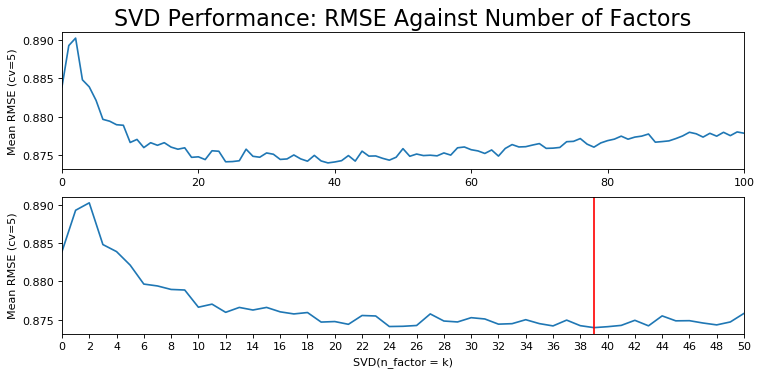

In [10]:
# import the rmse_svd csv file and clean the data
rmse_mean = pd.read_csv('Mean RMSE 5-fold CV Data.csv')
rmse_mean_d = rmse_mean['Mean RMSE'].apply(lambda rmse: float(rmse[:-1]))
rmse_list = rmse_mean_d.tolist()

# RMSE Against Number of Factors
def plot_rmse(rmse_list, algorithm):
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(2,1,1)
    plt.plot(rmse_list)
    plt.xlim(0,100)
    plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
    plt.ylabel("Mean RMSE (cv=5)")

    plt.subplot(2,1,2)
    plt.plot(rmse_list)
    plt.xlim(0,50)
    plt.xticks(np.arange(0, 52, step=2))

    plt.xlabel("{0}(n_factor = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")
    plt.axvline(np.argmin(rmse_list), color = "r")

plot_rmse(rmse_list,"SVD")

From our cross validation result, when the latent factor is really low, the model is underfitted and the RMSE is relatively high. The RMSE keeps decreasing until the factor is over 40 when the training set is an overfit representation of user tastes. We find the best estimator performance of k = 39 and the RMSE is around the 0.87. One thing to notice is that even when the k is 24, the RMSE is not bad at all. Now it's time to train our model.

In [11]:
# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD(n_factors = 39)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8695
RMSE: 0.8716
RMSE: 0.8670
RMSE: 0.8706
RMSE: 0.8720


We can take a look of the predictions.

In [12]:
predictions[0:2]

[Prediction(uid=3312, iid=2100, r_ui=3.0, est=2.9314936290239864, details={'was_impossible': False}),
 Prediction(uid=4812, iid=2458, r_ui=3.0, est=2.282164670864508, details={'was_impossible': False})]

### SVD Recommendation

The prediction contains user_id(uid), movie_id(iid), rating score(r_ui) and estimated rating score(est). We want map the prediction to each user and return the top 10 movies to which the user give the highest rating score. Besides, we also want to give some details about the prediction such as movie title and genres. For the code below, we randomly choose 318 as an example for model evaluation.

In [58]:
def get_top_n(predictions, UserID, n = 10):
    
    # First map the predictions to each user: {user:list[(movie_id, est_rating), (movie_id, est_rating)...]}
    # Surprise documentation: https://surprise.readthedocs.io/en/stable/predictions_module.html
        # uid – The (raw) user id. 
        # iid – The (raw) item id. 
        # r_ui (float) – The true rating 𝑟𝑢𝑖.
        # est (float) – The estimated rating r^𝑢𝑖.
        
    top_n = defaultdict(list)
    for user_id, movie_id, true_r, est_r, detail in predictions:
        top_n[user_id].append((movie_id, est_r))

    # Then sort the predictions for each user by the estimated rating and find top k movie_id
    for user_id, movie_ratings in top_n.items():
        movie_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[user_id] = movie_ratings[: n]
        return top_n[user_id]

def recommendation(user_id, predictions):
    movie_rating_list = get_top_n(predictions, user_id, n=10)
    preds_list = pd.DataFrame(movie_rating_list, columns=["MovieId", "EstRating"])
    preds_df = pd.DataFrame(preds_list.merge(df_movies, on='MovieId', how='left'))[['Title', 'Genres', 'EstRating']]
    print(preds_df)

recommendation(318, predictions)

                                               Title  \
0                                 Matrix, The (1999)   
1                                 Heavy Metal (1981)   
2                                  Dead Again (1991)   
3                 Big Trouble in Little China (1986)   
4                             American Beauty (1999)   
5                   Kentucky Fried Movie, The (1977)   
6                                      Kundun (1997)   
7  Star Wars: Episode V - The Empire Strikes Back...   
8                          North by Northwest (1959)   
9   Star Wars: Episode I - The Phantom Menace (1999)   

                                     Genres  EstRating  
0                    Action|Sci-Fi|Thriller   4.324920  
1  Action|Adventure|Animation|Horror|Sci-Fi   4.020811  
2                  Mystery|Romance|Thriller   4.019110  
3                             Action|Comedy   3.836818  
4                              Comedy|Drama   3.835161  
5                                    Come

### Model Evaluation


To evaluate the performance of our model, we also need to know the details of movies which the user has already rated, so we can see the latent factor that our model incorporates.

In [60]:
def moviesRatedAlready(user_id, predictions):
    # the movies that the user has already rated
    movies_rated_already = df_ratings[df_ratings['UserID'] == user_id]
    rated_list = movies_rated_already.merge(df_movies, on='MovieId', how='left')[['Title', 'Genres', 'Rating']].sort_values('Rating', ascending=False,)
    rated_df = pd.DataFrame(rated_list)
    # general user information
    user_info = df_users[df_users['UserID'] == user_id]
    print('User information:'+'\n') 
    print(user_info)
    print('\n')
    print('Movies which has already been rated:'+'\n')    
    print(rated_df)
    
moviesRatedAlready(318, predictions)

User information:

     UserID Gender  Age  Occupation Zip-code
317     318      F   56          13    55104


Movies which has already been rated:

                                         Title                         Genres  \
20                         Blood Simple (1984)                Drama|Film-Noir   
18                          Chicken Run (2000)    Animation|Children's|Comedy   
4                    Gone with the Wind (1939)              Drama|Romance|War   
5                             Elizabeth (1998)                          Drama   
7                         Bug's Life, A (1998)    Animation|Children's|Comedy   
12  Taking of Pelham One Two Three, The (1974)                         Action   
11                         Ghostbusters (1984)                  Comedy|Horror   
19              Poseidon Adventure, The (1972)               Action|Adventure   
15                        Out of Africa (1985)                  Drama|Romance   
14                                Diner (

Now we can evaluate the model on an individual level by observing the predicted movies and the user's historical rating. 

From the movies which the user has already rated, she/he seems very like movies with the tags in drama, action, comedy and thriller. When we look at the predictions from SVD model, it makes sense that most of the recommended movies are from those genres. However, the SVD model also recommends Star Wars series, which are very popular movies and we are not sure if there is a popular biase which the model will recommend popular movies.

## Conclusion

In conclusion, the SVD model gives pretty good recommendation because the RMSE is around 0.87 when we choose 39 as our optimal latent factor. We optimize the model in two ways. Firstly, we clean some outliers and noise in the dataset by only including the users who rate at least 5 movies and movies who are rated at least two times. Secondly, when we are running the 5-fold cross validation to find the optimal k, we use multithreading to reduce the running time. Through the exploratory analysis and our understanding of the model, here are some of the merits of SVD:

* Scalability: SVD can scales significantly better to larger datasets, since we can actually approximate the SVD with gradient descent.

* Better prediction on user's taste: even though we didn't use genres as a feature in the model, the recommender system does recommend movies from the genres which the user gives higher rating score. This reflects that the SVD picks up underlying preference and taste.

However, there are also some areas we can improve on or think about:

* Recommendation Accuracy: we use RMSE to evaluate our model but this might not be the best one. Let's take a look of the extreme case where user A only like horror movies and gives 5 to some horro movies and 0 to the rest but user B only like romantic movies and gives 5 to romantic movies and 0 to the rest. Based on our RMSE equation, the romantic movie lover might get the recommendation from horror movies because the RMSE would be the same. <img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

* Popularity Bias: from our exploratory analysis, we find that the movies which are most frequently rated usually get higher scores. The distribution is skewed to the left. We also want to recommend the movies which has few number of rate.